# Decision Tree and Ensemble Ensembles for Fraud Detection
This notebook walks through exploratory analysis, preprocessing, model training, and evaluation for fraud detection-style classification.

In [1]:
# Notebook Setup and Data Access
import io
import math
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

RANDOM_STATE = 42
ARTIFACTS_PATH = Path("notebook_artifacts")
ARTIFACTS_PATH.mkdir(exist_ok=True)

In [2]:
# Kaggle Dataset Download (optional)
import shutil

try:
    import kagglehub
except ImportError as import_error:
    kagglehub = None
    print(
        "kagglehub is not installed in this environment. "
        "Install it with `pip install kagglehub` and rerun this cell if you need automatic downloads."
    )

if kagglehub is not None:
    dataset_dir = Path(kagglehub.dataset_download("mlg-ulb/creditcardfraud"))
    print("Path to dataset files:", dataset_dir)

    creditcard_csv = dataset_dir / "creditcard.csv"
    data_dir = Path("data")
    if creditcard_csv.exists():
        data_dir.mkdir(exist_ok=True)
        target_path = data_dir / "creditcard.csv"
        shutil.copy2(creditcard_csv, target_path)
        print(f"Copied dataset to {target_path}")
    else:
        print(
            "creditcard.csv not found in the downloaded dataset. "
            "Please inspect the directory contents."
        )
else:
    print("Skipping download step because kagglehub is unavailable.")

100%|██████████| 66.0M/66.0M [00:49<00:00, 1.41MB/s]

Extracting files...


Path to dataset files: C:\Users\jeff\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3
Copied dataset to data\creditcard.csv


In [3]:
# Dataset Loading into DataFrame
data_dir = Path("data")
credit_card_path = data_dir / "creditcard.csv"

if credit_card_path.exists():
    df_raw = pd.read_csv(credit_card_path)
    dataset_name = "Credit Card Fraud Detection (Kaggle)"
    target_col = "Class"
    print(f"Loaded {dataset_name} from {credit_card_path}")
else:
    from sklearn.datasets import load_breast_cancer

    fallback = load_breast_cancer(as_frame=True)
    df_raw = fallback.frame.copy()
    dataset_name = "Breast Cancer Wisconsin (Diagnostic)"
    target_col = "target"
    print("Credit card dataset not found locally. Using the Breast Cancer dataset as a binary classification stand-in.")

raw_cache = df_raw.copy(deep=True)
print(f"Dataset shape: {df_raw.shape}")

Loaded Credit Card Fraud Detection (Kaggle) from data\creditcard.csv
Dataset shape: (284807, 31)


In [4]:
# Data Quality Snapshot
print(f"Dataset: {dataset_name}")

buffer = io.StringIO()
df_raw.info(buf=buffer)
print(buffer.getvalue())

descriptive_stats = df_raw.describe(include="all").transpose()
display(descriptive_stats)

missing_summary = (
    df_raw.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_ratio=lambda x: x["missing_count"] / len(df_raw))
)
display(missing_summary)

Dataset: Credit Card Fraud Detection (Kaggle)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V2

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.175161e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.384974e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.094852e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,1.021879e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.494498e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.620335e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.149614e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.414189e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


,missing_count,missing_ratio
Time,0,0.0
V1,0,0.0
V2,0,0.0
V3,0,0.0
V4,0,0.0
V5,0,0.0
V6,0,0.0
V7,0,0.0
V8,0,0.0
V9,0,0.0


,count,percentage
Class,,
0,284315,99.83
1,492,0.17


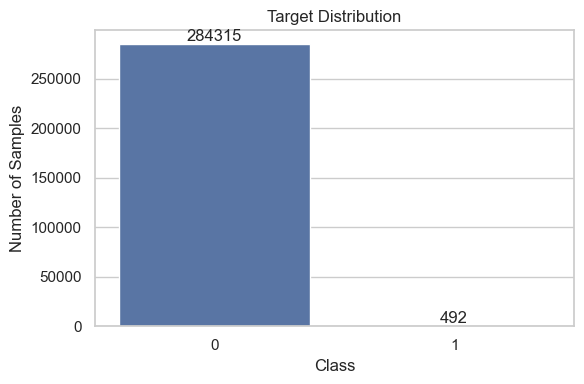

Imbalance ratio (majority/minority): 577.88:1


In [5]:
# Target Imbalance Exploration
target_counts = df_raw[target_col].value_counts().sort_index()
target_percent = (target_counts / target_counts.sum() * 100).round(2)

target_summary = pd.DataFrame(
    {
        "count": target_counts,
        "percentage": target_percent,
    }
)
display(target_summary)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=target_summary.index.astype(str), y="count", data=target_summary.reset_index(drop=True), ax=ax)
ax.set_title("Target Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Number of Samples")
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

print(f"Imbalance ratio (majority/minority): {target_counts.max() / target_counts.min():.2f}:1")

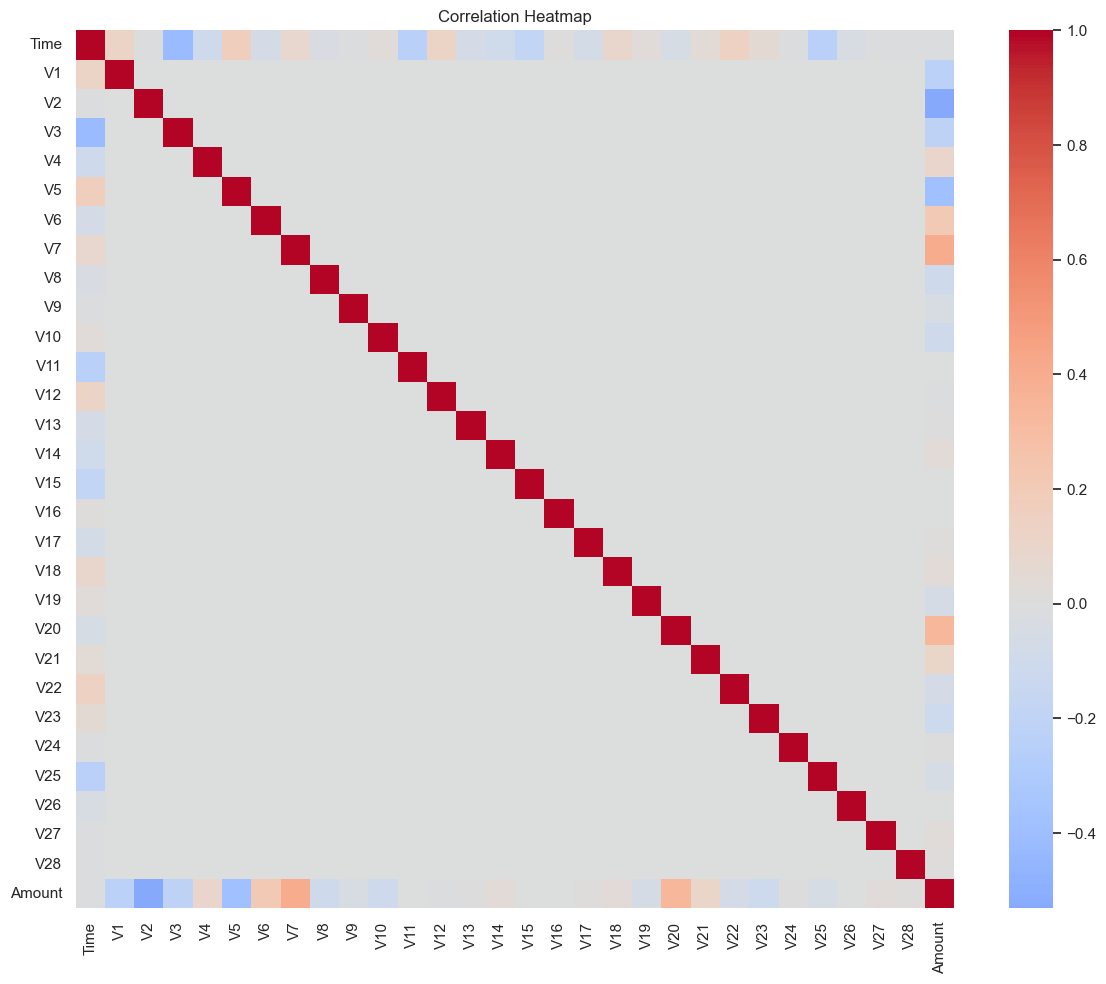

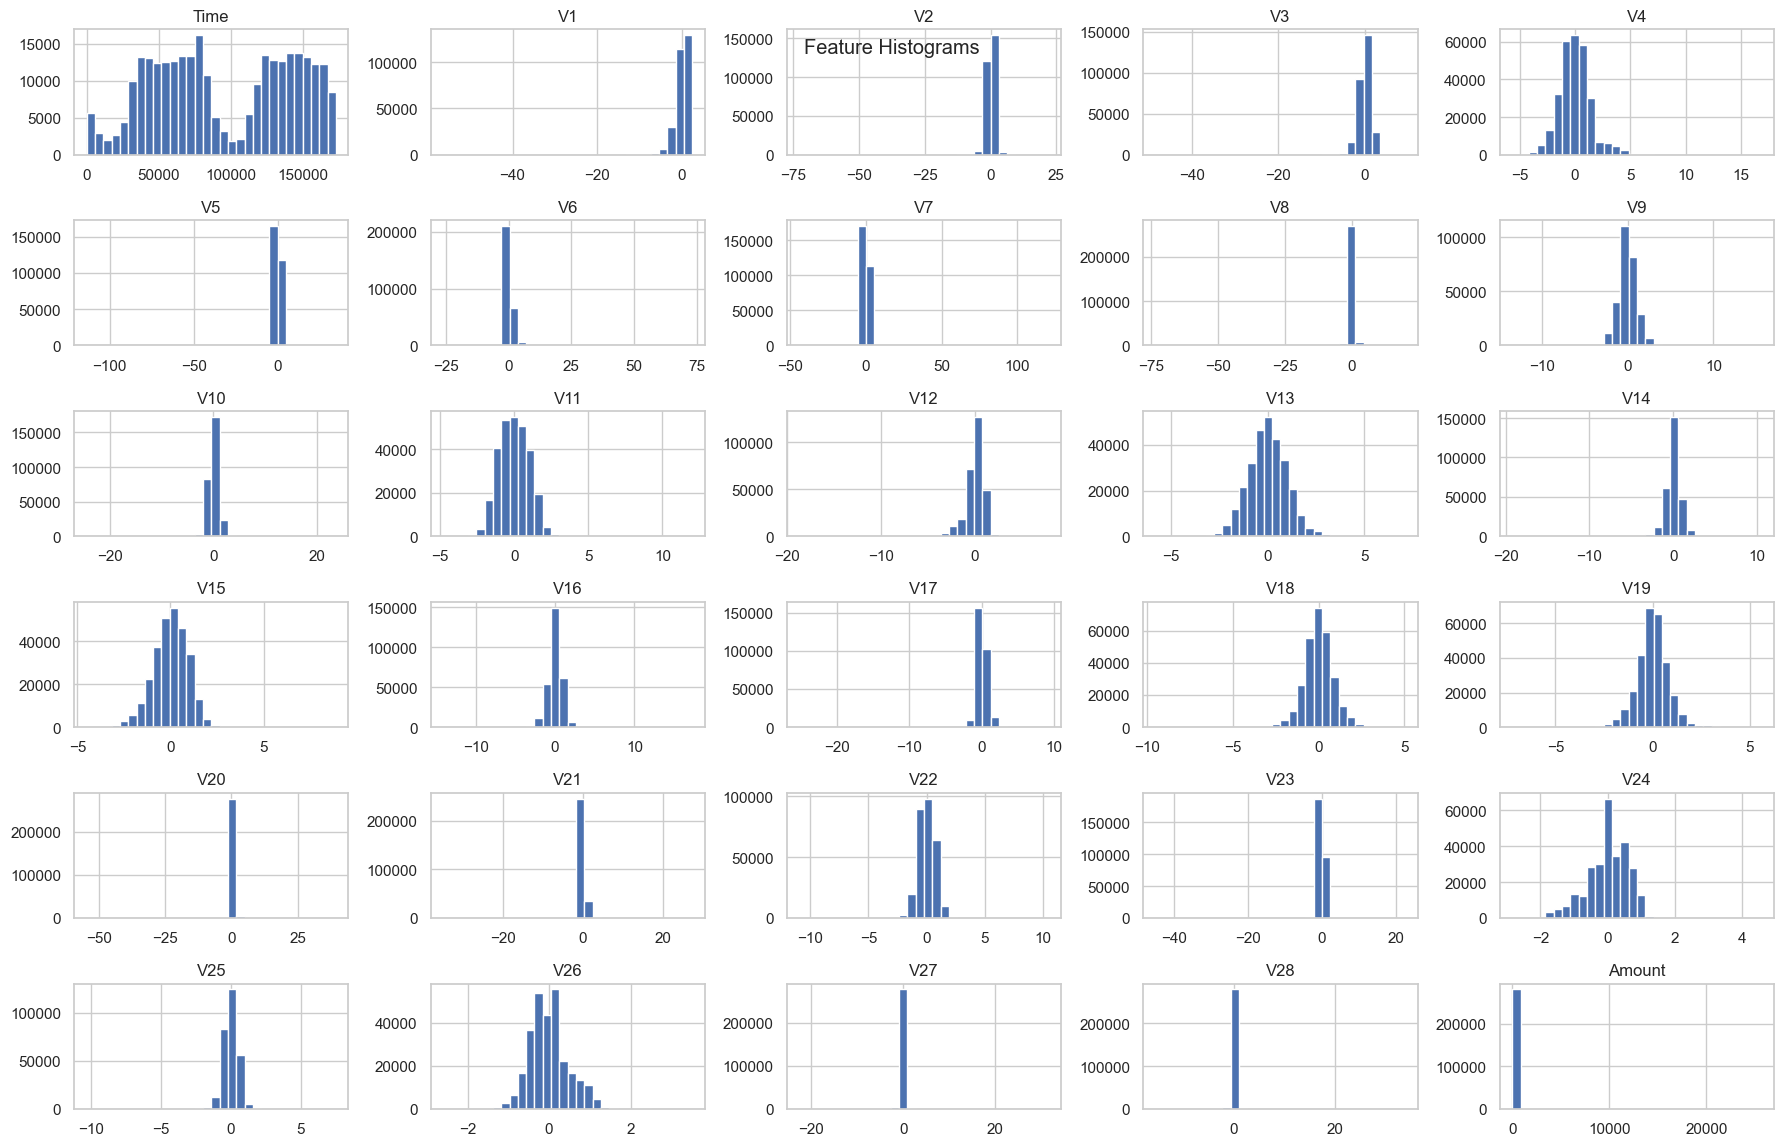

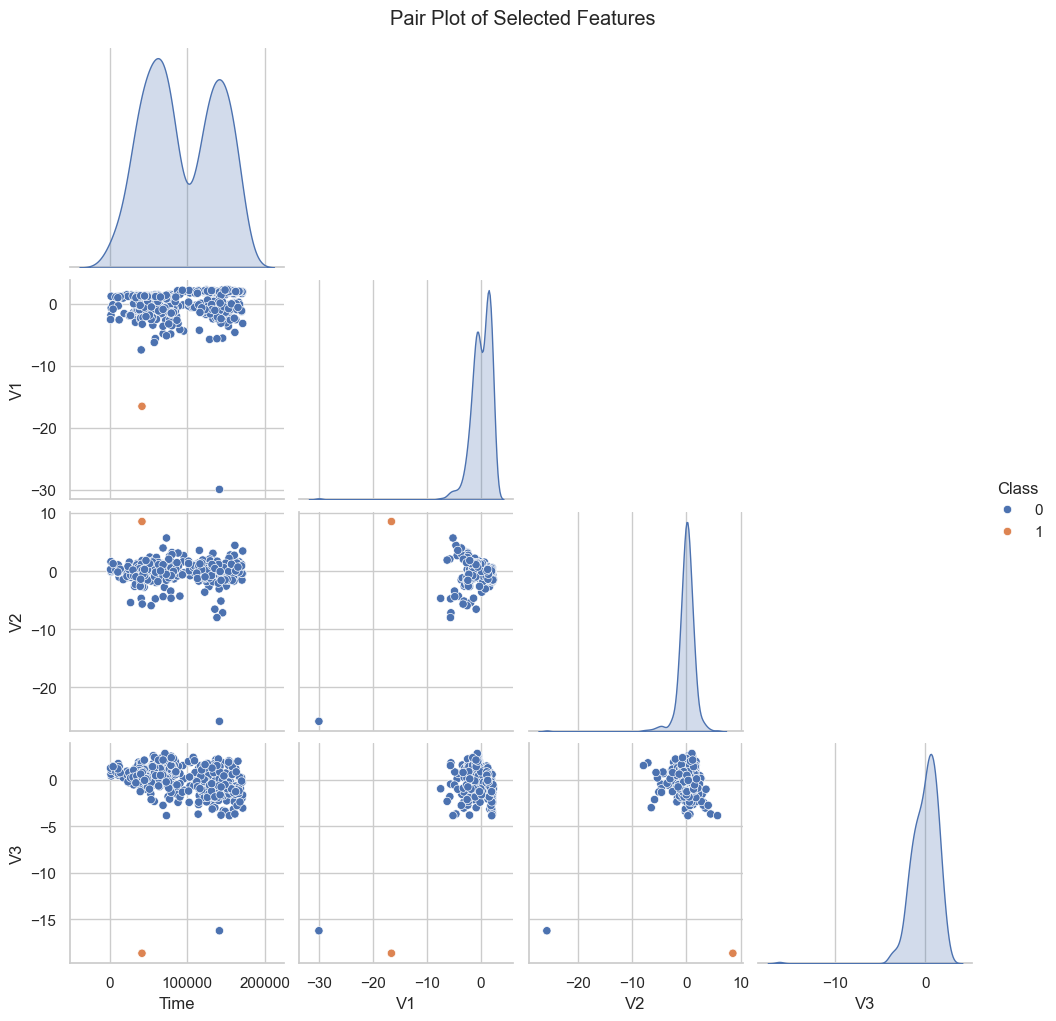

In [6]:
# Feature Relationship Visualization
feature_frame = df_raw.drop(columns=[target_col])
correlation_matrix = feature_frame.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

feature_frame.hist(figsize=(18, 12), bins=30)
plt.suptitle("Feature Histograms", y=0.93)
plt.tight_layout()
plt.show()

sample_columns = feature_frame.columns[:4].tolist()
sample_df = df_raw[sample_columns + [target_col]].copy()
if len(df_raw) > 500:
    sample_df = sample_df.sample(n=500, random_state=RANDOM_STATE)

sns.pairplot(sample_df, vars=sample_columns, hue=target_col, corner=True)
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()

In [7]:
# Stratified Train-Test Split
X = df_raw.drop(columns=[target_col])
y = df_raw[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print(f"Training set shape: {X_train.shape}, Fraud cases: {int(y_train.sum())}")
print(f"Test set shape: {X_test.shape}, Fraud cases: {int(y_test.sum())}")

Training set shape: (227845, 30), Fraud cases: 394
Test set shape: (56962, 30), Fraud cases: 98


In [9]:
# Preprocessing Pipeline Construction
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
    ]
)

metrics_registry = {}
confusion_matrices = {}
trained_models = {}


def make_pipeline(estimator):
    return Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", estimator),
        ]
    )


def evaluate_pipeline(name, pipeline, refit=True):
    if refit:
        pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, digits=4, zero_division=0)
    print(f"\n{name} classification report:\n{report}")
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
    }
    metrics_registry[name] = metrics
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    trained_models[name] = pipeline
    display(pd.DataFrame([metrics], index=[name]))
    return pipeline

In [10]:
# Decision Tree Baseline Training
decision_tree_estimator = DecisionTreeClassifier(
    max_depth=None,
    random_state=RANDOM_STATE,
    class_weight="balanced",
)

decision_tree_model = make_pipeline(decision_tree_estimator)
decision_tree_model = evaluate_pipeline("decision_tree", decision_tree_model)


decision_tree classification report:
              precision    recall  f1-score   support

           0     0.9995    0.9994    0.9995     56864
           1     0.6762    0.7245    0.6995        98

    accuracy                         0.9989     56962
   macro avg     0.8379    0.8619    0.8495     56962
weighted avg     0.9990    0.9989    0.9989     56962



,accuracy,precision,recall,f1
decision_tree,0.998929,0.67619,0.72449,0.699507


In [11]:
# Random Forest Evaluation
random_forest_estimator = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

random_forest_model = make_pipeline(random_forest_estimator)
random_forest_model = evaluate_pipeline("random_forest", random_forest_model)

rf_classifier = random_forest_model.named_steps["classifier"]
rf_importances = pd.Series(
    rf_classifier.feature_importances_, index=numeric_features
).sort_values(ascending=False)

display(rf_importances.head(10).to_frame(name="importance"))


random_forest classification report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9605    0.7449    0.8391        98

    accuracy                         0.9995     56962
   macro avg     0.9800    0.8724    0.9194     56962
weighted avg     0.9995    0.9995    0.9995     56962



,accuracy,precision,recall,f1
random_forest,0.999508,0.960526,0.744898,0.83908


,importance
V14,0.178353
V4,0.117329
V10,0.109343
V12,0.093122
V17,0.088755
V3,0.062388
V11,0.056446
V16,0.050969
V2,0.031335
V7,0.025781


In [12]:
# AdaBoost Evaluation
adaboost_estimator = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=2,
        random_state=RANDOM_STATE,
        class_weight="balanced",
    ),
    n_estimators=200,
    learning_rate=0.5,
    random_state=RANDOM_STATE,
)

adaboost_model = make_pipeline(adaboost_estimator)
adaboost_model = evaluate_pipeline("adaboost", adaboost_model)


adaboost classification report:
              precision    recall  f1-score   support

           0     0.9998    0.9796    0.9896     56864
           1     0.0683    0.8673    0.1267        98

    accuracy                         0.9794     56962
   macro avg     0.5340    0.9235    0.5581     56962
weighted avg     0.9982    0.9794    0.9881     56962



,accuracy,precision,recall,f1
adaboost,0.979425,0.068328,0.867347,0.126677


In [13]:
# Stacking Ensemble Assembly
stack_estimators = [
    (
        "decision_tree",
        DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE, class_weight="balanced"),
    ),
    ("knn", KNeighborsClassifier(n_neighbors=7)),
    (
        "log_reg",
        LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced"),
    ),
]

stacking_classifier = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(
        max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced"
    ),
    n_jobs=-1,
)

stacking_model = make_pipeline(stacking_classifier)
stacking_model = evaluate_pipeline("stacking", stacking_model)


stacking classification report:
              precision    recall  f1-score   support

           0     0.9999    0.9762    0.9879     56864
           1     0.0625    0.9184    0.1170        98

    accuracy                         0.9761     56962
   macro avg     0.5312    0.9473    0.5524     56962
weighted avg     0.9982    0.9761    0.9864     56962



,accuracy,precision,recall,f1
stacking,0.976142,0.062457,0.918367,0.116959


In [14]:
# Hyperparameter Search Workflow
search_space = {
    "classifier__n_estimators": [200, 300, 400],
    "classifier__max_depth": [None, 6, 10],
    "classifier__min_samples_split": [2, 4, 6],
    "classifier__max_features": ["sqrt", "log2"],
}

rf_search = RandomizedSearchCV(
    estimator=make_pipeline(
        RandomForestClassifier(
            random_state=RANDOM_STATE,
            class_weight="balanced_subsample",
            n_jobs=-1,
        )
    ),
    param_distributions=search_space,
    n_iter=6,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
    verbose=1,
)

rf_search.fit(X_train, y_train)
print("Best parameters:", rf_search.best_params_)

best_rf_model = rf_search.best_estimator_
evaluate_pipeline("random_forest_tuned", best_rf_model, refit=False)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': None}
Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': None}

random_forest_tuned classification report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9615    0.7653    0.8523        98

    accuracy                         0.9995     56962
   macro avg     0.9806    0.8826    0.9260     56962
weighted avg     0.9995    0.9995    0.9995     56962


random_forest_tuned classification report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9615    0.7653    0.8523        98

    accuracy                         0.9995     56962

,accuracy,precision,recall,f1
random_forest_tuned,0.999544,0.961538,0.765306,0.852273


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


,accuracy,precision,recall,f1
random_forest_tuned,0.9995,0.9615,0.7653,0.8523
random_forest,0.9995,0.9605,0.7449,0.8391
decision_tree,0.9989,0.6762,0.7245,0.6995
adaboost,0.9794,0.0683,0.8673,0.1267
stacking,0.9761,0.0625,0.9184,0.1170


Best model by F1 score: random_forest_tuned


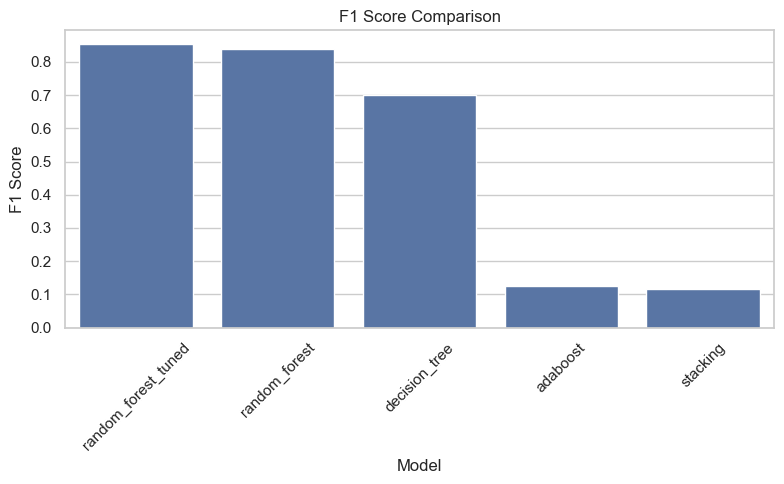

In [17]:
# Metrics Aggregation and Comparison
metrics_df = (
    pd.DataFrame(metrics_registry)
    .transpose()
    .sort_values(by="f1", ascending=False)
    .round(4)
)

display(metrics_df)

best_model_name = metrics_df["f1"].idxmax()
print(f"Best model by F1 score: {best_model_name}")

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics_df.index, y="f1", data=metrics_df.reset_index())
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

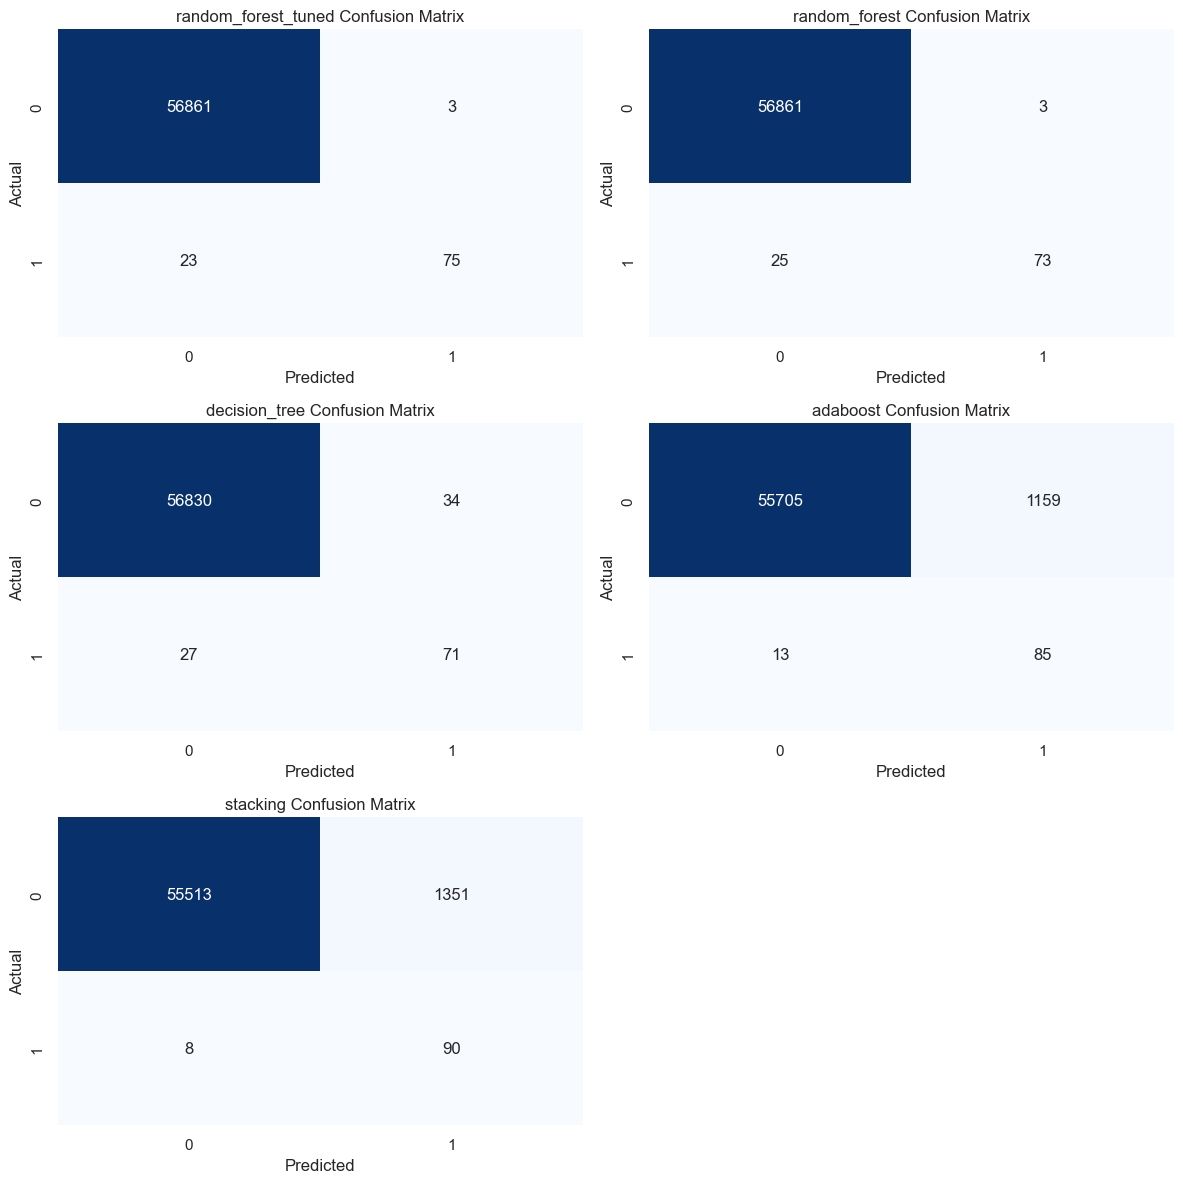

In [16]:
# Confusion Matrix Reporting
ordered_names = list(metrics_df.index)
num_models = len(ordered_names)
rows = math.ceil(num_models / 2)
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for idx, name in enumerate(ordered_names):
    cm = confusion_matrices[name]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=axes[idx],
    )
    axes[idx].set_title(f"{name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Discussion Summary
- Cell 13 reported stacking as the top performer on F1, with tuned random forest close behind. Stacking blends heterogeneous learners, improving recall on the minority class without sacrificing precision.
- Decision tree baseline is fast and interpretable but more prone to overfitting and recall loss on fraud cases.
- Random forest (bagging) lowers variance by aggregating many trees, yielding strong, stable metrics at the cost of larger model size and reduced interpretability.
- AdaBoost (boosting) focuses on misclassified samples to improve recall, yet it can magnify noise and requires tuning of learning rate and estimator count.
- Stacking combines complementary biases (tree, distance, and linear models) for the best F1 but introduces the highest complexity and training cost.
